# CP 217: ML4CPS Workshop Week 7

## Week 7 Worksheet:   Perceptron from Scratch

## Perceptron Learning

In this week, we will implement perceptron model from scratch. We again start with generating training data. As you saw in the lectures a perceptron is a linear classifier. Therefore, we will aim to generate linearly separable data.

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1024)
%matplotlib inline

In [2]:
def generate_s_shaped_data(gap=3):
    x = np.random.randn(80, 2)

    x[10:20] += np.array([3, 4]) ## keep this datapoints centered at mean (3,4) for (x,y)
    x[20:30] += np.array([0, 8])
    x[30:40] += np.array([3, 12])

    x[40:50] += np.array([gap, 0])
    x[50:60] += np.array([3 + gap, 4])
    x[60:70] += np.array([gap, 8])
    x[70:80] += np.array([3 + gap, 12])

    y = np.hstack([-np.ones(40), np.ones(40)])
    
    d = collections.namedtuple('Dataset', ['x', 'y'])
    d.x = x
    d.y = y
    return d

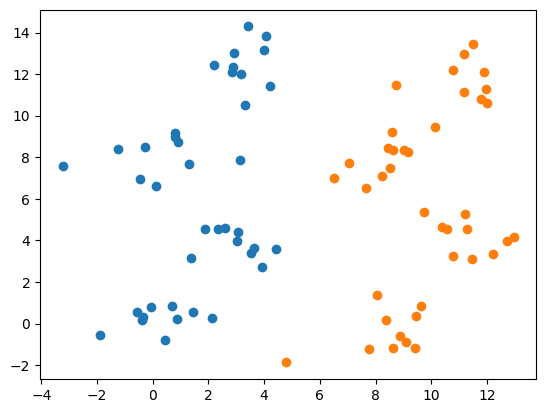

In [3]:
d = generate_s_shaped_data(8)
x = d.x
y = d.y

plt.plot(x[y==-1,0], x[y==-1,1], "o")
plt.plot(x[y==1,0], x[y==1,1], "o")

### Perceptron algorithm

Next we will train a binary classifier on this data. For this we’ll use the perceptron algorithm, which
you should recall takes a model of the form
$$
s(\mathbf{x}) = w_0 + \mathbf{w}^T \mathbf{x}
$$

$$
\text{predict}(\mathbf{x}) = \begin{cases} 
1, & \text{if } s(\mathbf{x}) \geq 0 \\
-1, & \text{otherwise}
\end{cases}
$$

Please refer to the lecture notes and the text book for a detailed exposition of the perceptron algorithm and linear classification models in general. Note that we treat $\mathbf{x}$ as a vector above, here it has two elements, one for each of the input dimensions. How many elements must there be in the weight vector $\mathbf{w}$?  

For simplicity, we will use the standard trick to incorporate the bias term $w_0$ into the weights $\mathbf{w}$ by using a basis function $\phi(x_1, x_2) = [1~x_1~x_2]^T$ which adds an extra constant dimension. The model becomes
$$ s(\mathbf{x}) = \mathbf{w}^T \phi(\mathbf{x}) $$
To do this, simply concatenate a column of 1s to the data matrix.

In [4]:
Phi = np.column_stack([np.ones(x.shape[0]), x])
Phi

array([[ 1.        ,  2.12444863,  0.25264613],
       [ 1.        ,  1.45417876,  0.56923979],
       [ 1.        ,  0.45822365, -0.80933344],
       [ 1.        ,  0.86407349,  0.20170137],
       [ 1.        , -1.87529904, -0.56850693],
       [ 1.        , -0.06510141,  0.80681666],
       [ 1.        , -0.5778176 ,  0.57306064],
       [ 1.        , -0.33667496,  0.29700734],
       [ 1.        , -0.37480416,  0.15510474],
       [ 1.        ,  0.70485719,  0.8452178 ],
       [ 1.        ,  2.34181921,  4.56810558],
       [ 1.        ,  3.51538125,  3.38435002],
       [ 1.        ,  3.92611427,  2.71408715],
       [ 1.        ,  4.43014026,  3.5745025 ],
       [ 1.        ,  2.59742288,  4.60410409],
       [ 1.        ,  1.36426542,  3.16681074],
       [ 1.        ,  3.06836691,  4.42213088],
       [ 1.        ,  3.61955926,  3.61580371],
       [ 1.        ,  3.02187841,  3.96553189],
       [ 1.        ,  1.86052589,  4.52776351],
       [ 1.        ,  0.78694952,  9.168

Note that Phi now has $3$ columns. In this array, each training instance is a row and each column is a feature. From now on we will use Phi instead of x. Each row represents $\phi(\mathbf{x})$ for a training instance.

### Prediction function

Next, write the prediction function (aka discriminant). This takes as input a data point (a row from Phi, i.e., a vector of 3 numbers) and the model parameters ($\mathbf{w}$) and outputs predicted label $1$ or $-1$. Recall that if $s(\mathbf{x})=0$, the predicted class is $1$.

In [5]:
def perc_pred(phi, w):
    s = np.sign(np.sign(np.dot(phi, w)) + 0.1)
    return s

Don't forget to test your prediction function with some examples! Note that it's more useful if it can support phi inputs both as vectors (returning a scalar, either +1/-1) and as matrices (returning a vector of +1/-1 values). The latter allows for you to supply a full dataset in one call.

In [6]:
print(perc_pred([1, 0, 1], [1, 2, 3]))
print(perc_pred(Phi, [1,2,3]))

1.0
[ 1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.]


### Training algorithm

Now for training algorithm which fits the weights, $\mathbf{w}$, to the training data. Recall that this is an online training algorithm, and we are going to iterate through the training examples one by one. Moreover, we are going to do several cycles, called *epochs*, such that we iterate through the entire training set within one epoch. Write a function called *train* which takes the basis data matrix *Phi*, the labels *t* and a number of epochs. This should implement the following pseudo-code:

> initialise weights to zero 

> repeat epoch times

> >   for each x and y pair in the training set

> > >       if model prediction and y differ, make weight update

> return weights

The weight update in the inner loop is $\mathbf{w} \leftarrow \mathbf{w} + y\phi(\mathbf{x})$.
What is the purpose of this update?

Please complete the precition function below.

In [7]:
def train(data, target, epochs, w=[], eta=1):
    if len(w) == 0:
        w = np.zeros(data.shape[1])
    for e in range(epochs):
        for i in range(data.shape[0]):
            yhat = perc_pred(data[i], w)
            if yhat != target[i]:
                w = w + eta * target[i] * data[i]
    return w

Run your training algorithm for 5 epochs to learn the weights

In [8]:
w_hat = train(Phi, y, 5)
w_hat

array([-16.        ,  14.71269718,   1.40431774])

### Evaluation

We are going to use the proportion of misclassified cases as the quality measure.

In [9]:
Accuracy = f"{np.sum(perc_pred(Phi, w_hat) == y) / len(y):.2%}"
print(Accuracy)

66.25%


Inspect the weights learnt in training. Do these match your intuitions? Plot the decision boundary represented by the weights, $\mathbf{w}^T \phi(\mathbf{x}) = 0$. Solving for $x_2$ as a function of $x_1$ yields $x_2 = -\frac{w_0}{w_2} - \frac{w_1}{w_2} x_1$. Note that you can you *linspace* and *plot* for displaying the line. 

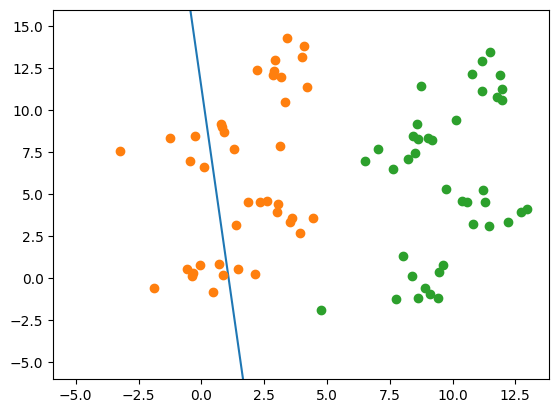

In [10]:
x1 = np.linspace(-5, 10, 100)
x2 = - w_hat[0] / w_hat[2] - w_hat[1] / w_hat[2] * x1

# plot the decision boundary 
plt.plot(x1, x2)
plt.ylim(-6, 16)
# plot the training data points
plt.plot(x[y==-1,0], x[y==-1,1], "o")
plt.plot(x[y==1,0], x[y==1,1], "o")


***Rerun your training with a larger number of epochs (10, 100, 1000), and evaluate how the accuracy changes.***

### Heldout evaluation

Evaluating on the training data is not a good idea in general, other than for debugging your algorithms. (Can you explain why?) We are going to generate another synthetic data thus essentially creating a fresh *heldout set*. What is the accuracy on this heldout data, and how does this compare to training accuracy?

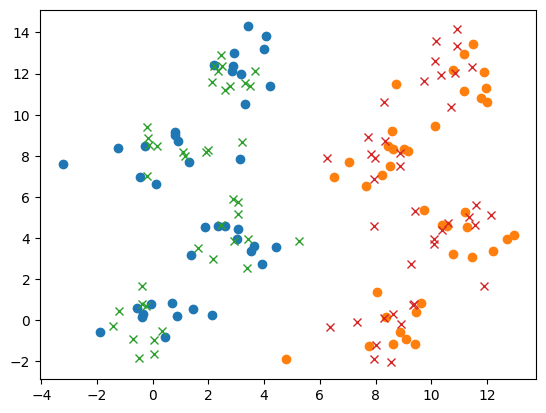

In [11]:
d_held = generate_s_shaped_data(8)
x_heldout = d_held.x 
y_heldout = d_held.y


plt.plot(x[y==-1,0], x[y==-1,1], "o")
plt.plot(x[y==1,0], x[y==1,1], "o")

# plot the heldout data points
plt.plot(x_heldout[y_heldout==-1,0], x_heldout[y_heldout==-1,1], "x")
plt.plot(x_heldout[y_heldout==1,0], x_heldout[y_heldout==1,1], "x")


Phi_heldout = np.column_stack([np.ones(x_heldout.shape[0]), x_heldout])

In [12]:
Accuracy = f"{np.sum(perc_pred(Phi_heldout, w_hat) == y_heldout) / len(y_heldout):.2%}"
print(Accuracy)

68.75%


Plot decision boundary for heldout data, together with training and heldout datapoints.

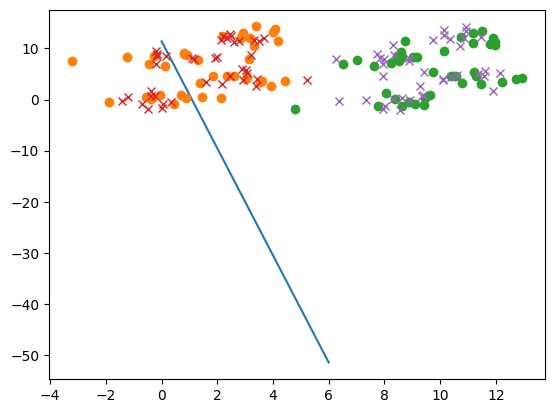

In [13]:
x1 = np.linspace(0, 6, 100)
x2 = - w_hat[0] / w_hat[2] - w_hat[1] / w_hat[2] * x1

# plot the decision boundary 
plt.plot(x1, x2)

# plot the training data points
plt.plot(x[y==-1,0], x[y==-1,1], "o")
plt.plot(x[y==1,0], x[y==1,1], "o")

# plot the heldout data points
plt.plot(x_heldout[y_heldout==-1,0], x_heldout[y_heldout==-1,1], "x")
plt.plot(x_heldout[y_heldout==1,0], x_heldout[y_heldout==1,1], "x")

How well does the decision boundary separate the points in the two classes? Where do you think the decision boundary should go? And how does the boundary change as you train for longer (more epochs)? Plot train and heldout errors as a function of number epochs. Note that careful tuning of the learning rate is needed to get sensible behaviour. Using $\eta = \frac{1}{1+e}$ where $e$ is the epoch number often works well.

Text(0, 0.5, 'Error')

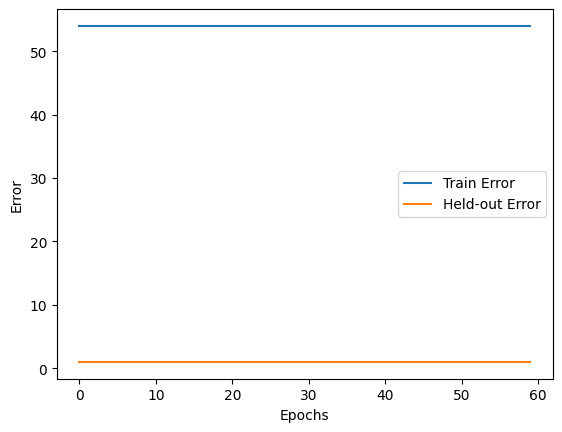

In [14]:
w_hat = []
T = 60
train_error = np.zeros(T)
heldout_error = np.zeros(T)
for e in range(T):
    # here we use a learning rate, which decays with each epoch
    lr = 1.0 / (1 + e)
    w_hat = train(Phi, y, 5)
    train_error[e] = np.sum(perc_pred(Phi, w_hat))
    heldout_error[e] = 1

plt.plot(train_error, label="Train Error")
plt.plot(heldout_error, label="Held-out Error")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")

Does the heldout error track the training error closely? Is the model (i.e., weights at a given epoch) on the training set the same as the best model on the heldout set?

Now, let's plot the decision boundary using w_hat

[-16.          14.71269718   1.40431774]


Text(0, 0.5, 'x2')

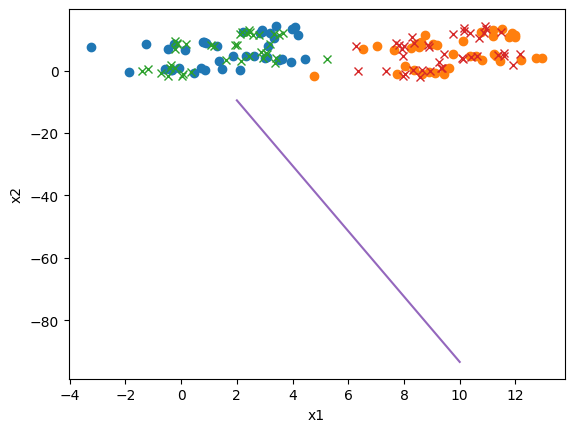

In [15]:
x1 = np.linspace(2, 10, 100)
print(w_hat)
x2 = - (w_hat[0] / w_hat[2]) - ((w_hat[1] / w_hat[2]) * x1)

# plot the training data points
plt.plot(x[y==-1,0], x[y==-1,1], "o")
plt.plot(x[y==1,0], x[y==1,1], "o")

# plot the heldout data points
plt.plot(x_heldout[y_heldout==-1,0], x_heldout[y_heldout==-1,1], "x")
plt.plot(x_heldout[y_heldout==1,0], x_heldout[y_heldout==1,1], "x")

# plot the decision boundary 
plt.plot(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')

Now generate training and heldout datasets that are not linearly separable, and investigate what happens to training and heldout errors with increasing number of epochs.

### Classification of SONAR Signals 
The task is to train a network to discriminate between sonar signals bounced off a metal cylinder(M)  and those bounced off a roughly cylindrical rock (R).

The dataset contains 111 patterns obtained by bouncing sonar signals off a metal cylinder (M) and 97 patterns obtained from rocks (R) at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. 

Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.

The label associated with each record contains the letter "R" if the object is a rock and "M" if it is a mine (metal cylinder).

You can learn more about this dataset on the UCI Machine Learning repository:
- https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks) 

In [16]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
dataframe = pd.read_csv("sonar_all_data.csv" , header=None)
dataset = dataframe.values

In [17]:
X = dataset[:,0:60].astype(float)
y = dataset[:,60]
y

array(['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M

In [18]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
encoded_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
encoded_y[encoded_y==0]=-1

In [20]:
Phi=np.column_stack([np.ones(X.shape[0]), X])
Phi

array([[1.    , 0.02  , 0.0371, ..., 0.0084, 0.009 , 0.0032],
       [1.    , 0.0453, 0.0523, ..., 0.0049, 0.0052, 0.0044],
       [1.    , 0.0262, 0.0582, ..., 0.0164, 0.0095, 0.0078],
       ...,
       [1.    , 0.0522, 0.0437, ..., 0.0138, 0.0077, 0.0031],
       [1.    , 0.0303, 0.0353, ..., 0.0079, 0.0036, 0.0048],
       [1.    , 0.026 , 0.0363, ..., 0.0036, 0.0061, 0.0115]])

In [21]:
Phi.shape

(208, 61)

In [22]:
# split data into train and test sets using Stratified Sampling
from sklearn.model_selection import train_test_split
Phi_train, Phi_test, y_train, y_test = train_test_split(Phi, encoded_y, test_size=0.3, stratify=y)

Text(0, 0.5, 'Error')

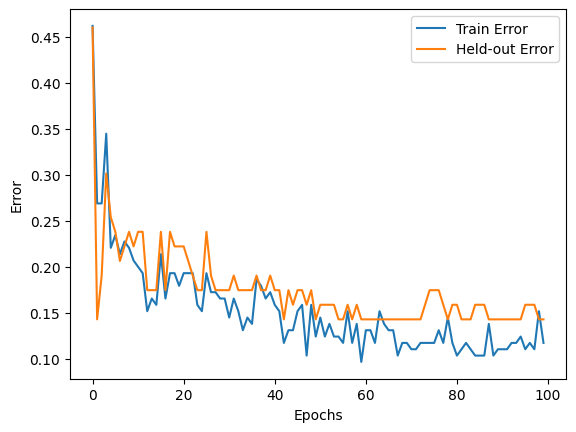

In [23]:
w_hat = np.zeros(Phi.shape[1])
T = 100
train_error = np.zeros(T)
heldout_error = np.zeros(T)
for e in range(T):
    lr= 1./(1+e)
    w_hat = train(Phi_train, y_train, 1, w_hat, eta= lr)
    train_error[e] = np.sum(perc_pred(Phi_train, w_hat) != y_train) / float(y_train.shape[0])
    heldout_error[e] = np.sum(perc_pred(Phi_test, w_hat) != y_test) / float(y_test.shape[0])


plt.plot(train_error, label = 'Train Error')
plt.plot(heldout_error, label = 'Held-out Error')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')

In [24]:
Accuracy = np.sum(perc_pred(Phi_test, w_hat) == y_test) / float(y_test.shape[0])
print(Accuracy)

0.8571428571428571


### References
1. Pattern Recognition and Machine Learning, Christopher Bishop, New York, Springer,  2006.
2. https://machinelearningmastery.com/implement-perceptron-algorithm-scratch-python/
3. Statistical Machine Learning Course Workshop, 2015, University of Melbourne, Australia